# Setup

In [1]:
DATA_FILE_VERSION = "2025-04-28"
DATA_FILE_NAME = f"consultation-documents-preprocessed-{DATA_FILE_VERSION}.parquet"
EXTRA_DOCUMENT_FEATURES_FILE_NAME = f"consultation-documents-features-{DATA_FILE_VERSION}.parquet"
EMBEDDINGS_FILE_NAME = (
    # f"consultation-documents-embeddings-beginnings-openai-text-embedding-3-large-{DATA_FILE_VERSION}.parquet"
    "consultation-documents-embeddings-beginnings-openai-text-embedding-3-large-2025-05-02.parquet"
)

LANGUAGES = {
    "de",
    # "fr",
    # "it",
}

FROM_YEAR = 2000

MERGE_CLASSES = {
    # (classes, to, drop): replacement_class
    ("RESPONSE_FORM",): "SURVEY",
    ("DECISION", "PRESS_RELEASE"): "VARIOUS_TEXT",
}

INCLUDE_RULE_LABELS_IN_TRAINING = {
    "SYNOPTIC_TABLE",
    "LETTER",
    "RECIPIENT_LIST",
    "FINAL_REPORT",
}

CV_FOLDS = 5
TEST_SIZE = 0.1
RANDOM_STATE = 2718
USE_TEST_SET = True

In [2]:
%load_ext autoreload
%autoreload 2

import logging
import os
import pathlib
import sys
from typing import Any

import dotenv
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics
import sklearn.model_selection
import sklearn.utils.multiclass
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier  # noqa: F401
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler  # noqa: F401
from tqdm import tqdm

REPOSITORY_ROOT = (pathlib.Path().cwd() / ".." / "..").resolve()
sys.path.append(str(REPOSITORY_ROOT))

In [3]:
from research.document_types import data_loading, document_title_rule_model
from research.lib import data_access, plotting, utils

In [4]:
dotenv.load_dotenv()

True

In [5]:
if os.environ.get("MLFLOW_TRACKING_USERNAME") and os.environ.get("MLFLOW_TRACKING_PASSWORD"):
    mlflow.set_tracking_uri("https://mlflow.ml1.demokratis.ch/")
else:
    logging.warning("MLflow credentials not found, will track locally.")
    mlflow.set_tracking_uri("sqlite:///mlruns.db")

mlflow.set_experiment("VM_document_type_classifier")

if run := mlflow.active_run():
    logging.warning("Run = %s is already active, closing it.", run.info.run_name)
    mlflow.end_run()
run = mlflow.start_run()
print("Starting run:", run.info.run_name)
mlflow.log_param("input_file", DATA_FILE_NAME)
mlflow.log_param("extra_features_file", EXTRA_DOCUMENT_FEATURES_FILE_NAME)
mlflow.log_param("embeddings_file", EMBEDDINGS_FILE_NAME)
mlflow.log_param("languages", LANGUAGES)
mlflow.log_param("from_year", FROM_YEAR)
mlflow.log_param("cv_folds", CV_FOLDS)
mlflow.log_param("test_size", TEST_SIZE)
mlflow.log_param("random_state", RANDOM_STATE)
mlflow.log_param("include_rule_labels_in_training", sorted(INCLUDE_RULE_LABELS_IN_TRAINING))
mlflow.log_param("merge_classes", MERGE_CLASSES)
;

Starting run: trusting-doe-299


''

In [6]:
mlflow.sklearn.autolog()
tqdm.pandas()

2025/05/02 17:04:01 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.5.2, but the installed version is 1.6.0. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.


# Input data preparation

In [7]:
PREPROCESSED_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / DATA_FILE_NAME
data_access.ensure_dataframe_is_available(PREPROCESSED_DATA_FILE)

In [8]:
df_input, df_test_external = data_loading.load_documents(
    document_file=PREPROCESSED_DATA_FILE,
    external_test_labels_file=REPOSITORY_ROOT / "research" / "document_types" / "ground_truth.xlsx",
    only_languages=LANGUAGES,
    starting_year=FROM_YEAR,
    include_rule_labels=INCLUDE_RULE_LABELS_IN_TRAINING,
    class_merges=MERGE_CLASSES,
)

print("df_input labels:")
df_input.groupby("document_type_label_source")["document_type"].value_counts()

df_input labels:


document_type_label_source  document_type 
explicit                    LETTER            3419
                            DRAFT             3055
                            REPORT            2409
                            RECIPIENT_LIST    1914
                            FINAL_REPORT      1868
                            OPINION           1020
                            VARIOUS_TEXT       517
                            SYNOPTIC_TABLE     197
                            SURVEY              37
                            DECISION             0
                            LINK                 0
                            RESPONSE_FORM        0
rule                        LETTER            1362
                            SYNOPTIC_TABLE     671
                            RECIPIENT_LIST     548
                            FINAL_REPORT        82
                            DECISION             0
                            DRAFT                0
                            LINK       

In [9]:
df_test_external

,document_id,consultation_id,consultation_start_date,consultation_end_date,consultation_title,consultation_description,document_source_url,consultation_url,consultation_topics,consultation_internal_tags,...,political_body,latest_stored_file_id,document_source,consultation_topics_label_source,document_content_plain,stored_file_path,stored_file_mime_type,stored_file_hash,document_type_label_source,document_type
38521,38522,2317,2021-09-08,2021-12-09,Materielle und formelle Revision des Gebührenr...,,https://www.ag.ch/media/kanton-aargau/portal/a...,https://www.demokratis.ch/vernehmlassung/xnyvgkgk,"[economics, finance]",[],...,ag,<NA>,openparldata,openparldata,Synopse Beilage 1 zum Anhörungsbericht \n \nA...,None,None,None,external_test,SYNOPTIC_TABLE
38570,38571,2322,2022-02-20,2022-04-21,Anpassung des Richtplans; Verminderung der Fru...,,https://www.ag.ch/media/kanton-aargau/bvu/raum...,https://www.demokratis.ch/vernehmlassung/84ssk4vc,"[energy, environment, spatial_planning]",[],...,ag,<NA>,openparldata,openparldata,Axpo Power AG | Hydroenergie & Biomasse \n\nPa...,None,None,None,external_test,VARIOUS_TEXT
38660,38684,2339,2012-01-06,2012-02-06,Gemeinde Gontenschwil; Anpassung des Richtplans,,https://www.ag.ch/media/kanton-aargau/portal/a...,https://www.demokratis.ch/vernehmlassung/fs257a7u,[spatial_planning],[],...,ag,40174,openparldata,openparldata,j:\vernehmlassungen\vernehmlassungen\kanton\rp...,2024/2339/38684/1CMHFvwchtwhvVAGhERwUx.pdf,application/pdf,486e5734ef73a2feb2234b86eb2ccda62b3f43d0,external_test,REPORT
38664,38688,2340,2012-01-11,2012-04-13,eHealth; IDAG und des Gesundheitsgesetz; Teilr...,Der Bund wird voraussichtlich im Jahr 2015 ode...,https://www.ag.ch/media/kanton-aargau/portal/a...,https://www.demokratis.ch/vernehmlassung/69q4yzws,"[health, it]","[{'created_at': 2025-01-25 14:10:50, 'name': '...",...,ag,40171,openparldata,manual,Departement \nGesundheit und Soziales \nVorste...,2024/2340/38688/1CMHFvpmT837scS6K98QfL.pdf,application/pdf,9ef01b766efdc253cde3b01fd4752b99e1c63855,external_test,LETTER
38747,38771,2362,2012-12-10,2013-03-08,Gemeinde Würenlos; Anpassung des Richtplans,,https://www.ag.ch/media/kanton-aargau/portal/a...,https://www.demokratis.ch/vernehmlassung/nnuj5gx8,[spatial_planning],[],...,ag,<NA>,openparldata,openparldata,Gemeinde Würenlos Kanton Aargau \n___________...,None,None,None,external_test,REPORT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50521,52074,4835,2024-08-16,2024-11-11,Änderung des Finanzausgleichsgesetzes,"Der Regierungsrat hat in Aussicht gestellt, na...",https://sh.ch/CMS/get/file/f6cad1a9-895e-40d7-...,https://www.demokratis.ch/vernehmlassung/vwp33sb5,"[administration, public_finance, security]","[{'created_at': 2025-04-15 11:52:34, 'name': '...",...,sh,5796,openparldata,manual,Kanton Schaffhausen\nMedienkonferenz\nÄnderung...,2024/4835/52074/1CM2Lx6kBnu82sM9EBj2wc.pdf,application/pdf,f6119766677a6ef503956c9ef69ac108876f778d,external_test,VARIOUS_TEXT
50844,52424,4886,2024-09-13,2024-10-15,Änderung der Verordnung zum Einführungsgesetz ...,"Der Regierungsrat plant, die monatlichen Kinde...",https://zg.ch/dam/jcr:95397bc7-9729-4e66-9c3c-...,https://www.demokratis.ch/vernehmlassung/nmu3kfpv,"[economics, public_finance, social]","[{'created_at': 2025-04-08 13:47:48, 'name': '...",...,zg,6064,openparldata,manual,Amt für Gesundheit_3 \n \nÄnderung der Verord...,2024/4886/52424/1CM2MAHFJQhCLbd65xquDU.pdf,application/pdf,8b6a8ae3483311da1145da08d7a5f1d3b4e8a0f8,external_test,SURVEY
50963,52559,4901,2024-09-19,2024-10-31,Revision des Gesetzes über den Fristenlauf (FriG),Der Bund nimmt auf Anfang 2025 eine Änderung b...,https://www.ai.ch/politik/standeskommission/ka...,https://www.demokratis.ch/vernehmlassung/w4rqwc8a,"[administration, communications, law]","[{'created_at': 2024-10-16 10:51:54, 'name': '...",...,ai,6191,openparldata,manual,AI 013.25-27.71.5-1211726 1-2 \nLandammann un...,2024/4901/52559/1CM2MDcYW7HDAiDmhdErv4.pdf,appli

In [10]:
# # Test: remove documents known to have label issues
# document_ids_with_issues = pd.read_csv("cleanlab_1_document_ids.csv")
# df_input = df_input[~df_input["document_id"].isin(document_ids_with_issues["document_id"])]

## Drop empty documents

In [11]:
def drop_empty_texts(df: pd.DataFrame) -> pd.DataFrame:
    empty_index = df["document_content_plain"].str.strip() == ""
    empty_count = len(df[empty_index])
    print(f"Empty texts: {empty_count} ({100 * empty_count / len(df):.1f}%)")
    return df.loc[~empty_index]


print("df_input:", end=" ")
df_input = drop_empty_texts(df_input)
print("df_test_external:", end=" ")
df_test_external = drop_empty_texts(df_test_external)

df_input: Empty texts: 1028 (6.0%)
df_test_external: Empty texts: 7 (5.6%)


## Data representation

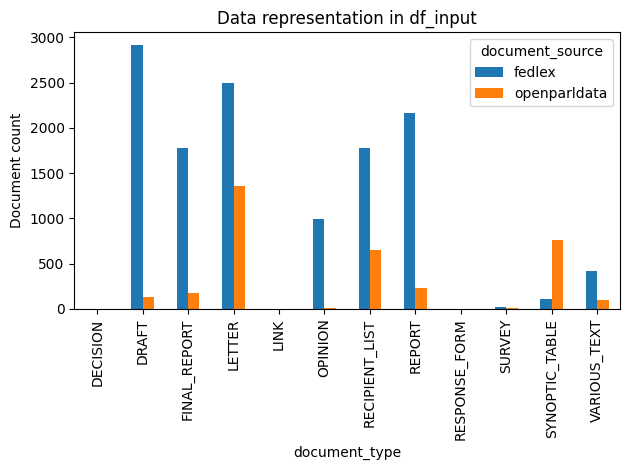

document_source,fedlex,openparldata
document_type,,
DECISION,0,0
DRAFT,2910,129
FINAL_REPORT,1773,171
LETTER,2492,1357
LINK,0,0
OPINION,992,8
RECIPIENT_LIST,1778,653
REPORT,2163,234
RESPONSE_FORM,0,0


In [12]:
repr_table = df_input.pivot_table(
    index="document_type", columns="document_source", aggfunc="size", fill_value=0, observed=False
)
display(
    plotting.plot_and_log(
        repr_table.plot,
        "data_representation.png",
        title="Data representation in df_input",
        kind="bar",
        ylabel="Document count",
    )
)
display(repr_table)

## Additional features

In [13]:
FEATURES_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / EXTRA_DOCUMENT_FEATURES_FILE_NAME
data_access.ensure_dataframe_is_available(FEATURES_DATA_FILE)

df_features = pd.read_parquet(FEATURES_DATA_FILE)
df_features

,,contains_table_on_first_page,count_pages,count_tables,count_pages_containing_tables,count_images,count_pages_containing_images,average_page_aspect_ratio
document_id,stored_file_hash,,,,,,,
1,b8816738ad84d806e55723a313613097bed2752f,False,26,0.0,0.0,0.0,0.0,0.704898
4,d47bb05bc7f135a0b850702336ecca328f7dafce,False,6,0.0,0.0,1.0,1.0,0.707098
7,fdcb391ccf2efd9b56a446e39284e3cceab5e4eb,False,2,0.0,0.0,1.0,1.0,0.707098
10,b631111878a9eea5ae89bdc7ce85d86c609856a3,False,15,0.0,0.0,13.0,6.0,0.707098
13,aa8dee571dc5bd912ba0adcc034dbda45f0b62c9,False,2,0.0,0.0,1.0,1.0,0.707098
...,...,...,...,...,...,...,...,...
54779,9380f8266b53161f927bff3732877fab106f4c1a,False,2,0.0,0.0,1.0,1.0,0.704898
54782,e918ab385f64f5a272a4f4031d99ca98b3742f6a,False,12,0.0,0.0,0.0,0.0,0.704898
54785,08ca3d187b368f0f965b5225119af3aecef1609d,False,2,0.0,0.0,3.0,2.0,0.707098


In [14]:
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    previous_shape = df.shape
    df = df.join(df_features, on=["document_id", "stored_file_hash"], how="inner")
    df["fraction_pages_containing_tables"] = df["count_pages_containing_tables"] / df["count_pages"]
    df["fraction_pages_containing_images"] = df["count_pages_containing_images"] / df["count_pages"]
    df["contains_synopse_keyword"] = (
        df["document_content_plain"].str.slice(0, 1000).str.contains("synopse", case=False, regex=False)
    )
    df["contains_salutation"] = (
        df["document_content_plain"]
        .str.slice(0, 3000)
        .str.contains(
            r"(?:Sehr\s+geehrte[r]?\s+(?:Frau|Herr|Damen\s+und\s+Herren)|"
            r"Liebe[r]?\s+(?:Frau|Herr|Damen\s+und\s+Herren)|"
            r"Sehr\s+geehrte[r]?\s+(?:"
            r"Bundesr(?:at|ätin)|"
            r"Regierungsr(?:at|ätin)|"
            r"Nationalr(?:at|ätin)|"
            r"Stadtpr[äa]sid(?:ent|entin)|"
            r"Gemeindepr[äa]sid(?:ent|entin)|"
            r"Stadtr(?:at|ätin)|"
            r"Gemeinder(?:at|ätin)|"
            r"Pr[äa]sid(?:ent|entin)))",
            case=False,
            regex=True,
        )
    )
    print(
        f"{previous_shape[0] - df.shape[0]} rows were lost due to missing features. Remaining rows: {df.shape[0]}. "
        f"{df.shape[1] - previous_shape[1]} columns were added."
    )
    return df

In [15]:
# df_input.join(df_features, on=["document_id", "stored_file_hash"], how="inner")

In [16]:
df_input = add_features(df_input)
df_test_external = add_features(df_test_external)

2600 rows were lost due to missing features. Remaining rows: 13471. 11 columns were added.
55 rows were lost due to missing features. Remaining rows: 64. 11 columns were added.


In [17]:
print("contains_salutation:")
df_input.pivot_table(
    index="document_type",
    columns="document_source",
    values="contains_salutation",
    aggfunc="mean",
    fill_value=0,
    observed=False,
)

contains_salutation:


document_source,fedlex,openparldata
document_type,,
DRAFT,0.001123,0.000000
FINAL_REPORT,0.003722,0.142857
LETTER,0.985458,0.975610
OPINION,0.746114,0.571429
RECIPIENT_LIST,0.000000,0.000000
REPORT,0.013078,0.069364
SURVEY,0.000000,0.000000
SYNOPTIC_TABLE,0.000000,0.000000
VARIOUS_TEXT,0.015113,0.000000


### Keyword-like features

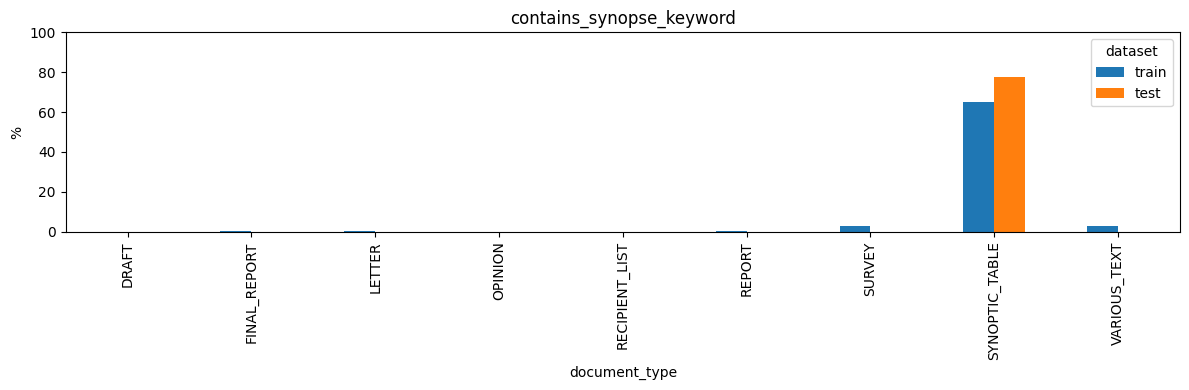

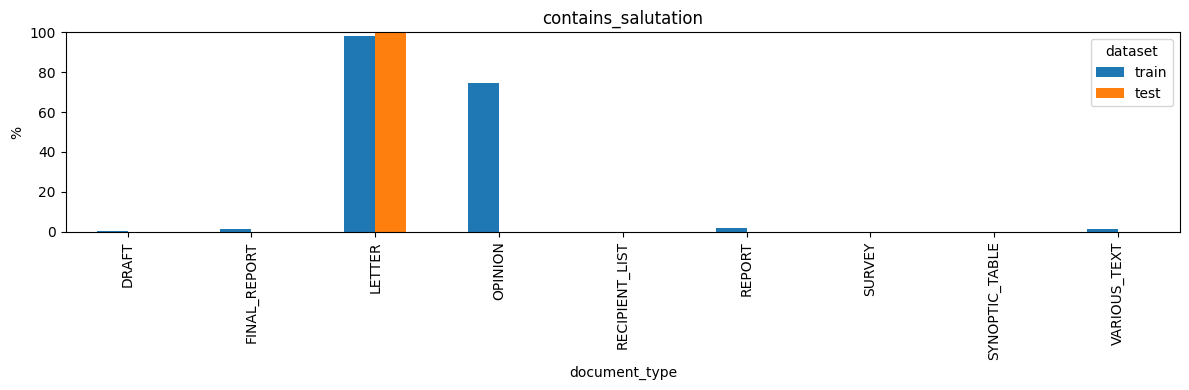

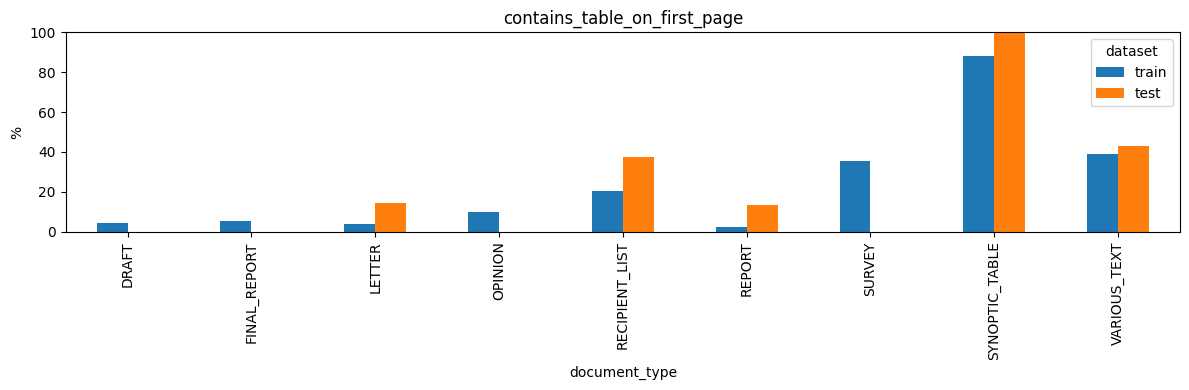

In [18]:
def plot_binary_feature_across_document_types(df_train: pd.DataFrame, df_test: pd.DataFrame, feature_name: str) -> None:
    df = pd.concat(
        [
            df_train[["document_type", feature_name]].assign(dataset="train"),
            df_test[["document_type", feature_name]].assign(dataset="test"),
        ],
        axis=0,
    )
    pivot_table = df.pivot_table(
        index="document_type",
        columns="dataset",
        values=feature_name,
        aggfunc=lambda x: 100 * x.mean(),
        fill_value=0,
        observed=False,
    )
    pivot_table = pivot_table[["train", "test"]]  # Ensure "train" comes first
    pivot_table.plot(
        kind="bar",
        figsize=(12, 4),
        title=feature_name,
        ylabel="%",
        ylim=(0, 100),
    )
    plt.tight_layout()
    plt.show()


plot_binary_feature_across_document_types(df_input, df_test_external, "contains_synopse_keyword")
plot_binary_feature_across_document_types(df_input, df_test_external, "contains_salutation")
plot_binary_feature_across_document_types(df_input, df_test_external, "contains_table_on_first_page")

In [19]:
def plot_feature_distribution_across_document_types(
    df_train: pd.DataFrame, df_test: pd.DataFrame, feature_name: str, clip_y: None | tuple[int, int] = None
) -> None:
    plt.figure(figsize=(14, 5))
    df = pd.concat(
        [
            df_train[["document_type", feature_name]].assign(dataset="train"),
            df_test[["document_type", feature_name]].assign(dataset="test"),
        ],
        axis=0,
    )
    ax = sns.violinplot(
        data=df,
        x="document_type",
        y=feature_name,
        hue="dataset",
        order=sorted(df["document_type"].unique()),
        # inner="box",  # Show boxplot inside violin
        inner=None,  # Show only violin
        split=True,
        linewidth=0.1,
    )
    plt.xticks(rotation=90)
    if clip_y:
        sample = df[feature_name].dropna()
        ax.set_ylim(*np.percentile(sample, clip_y))
        plt.title(f"{feature_name} (clipped to {clip_y[0]}-{clip_y[1]}th percentile)")
    else:
        plt.title(feature_name)
    plt.tight_layout()
    plt.show()

### Page count, aspect ratio

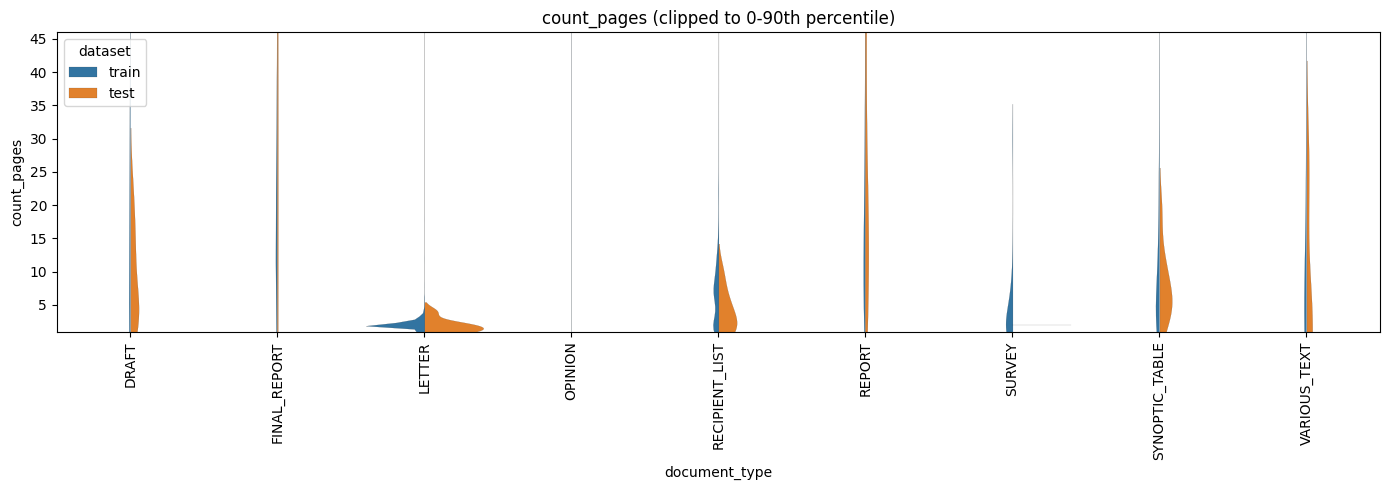

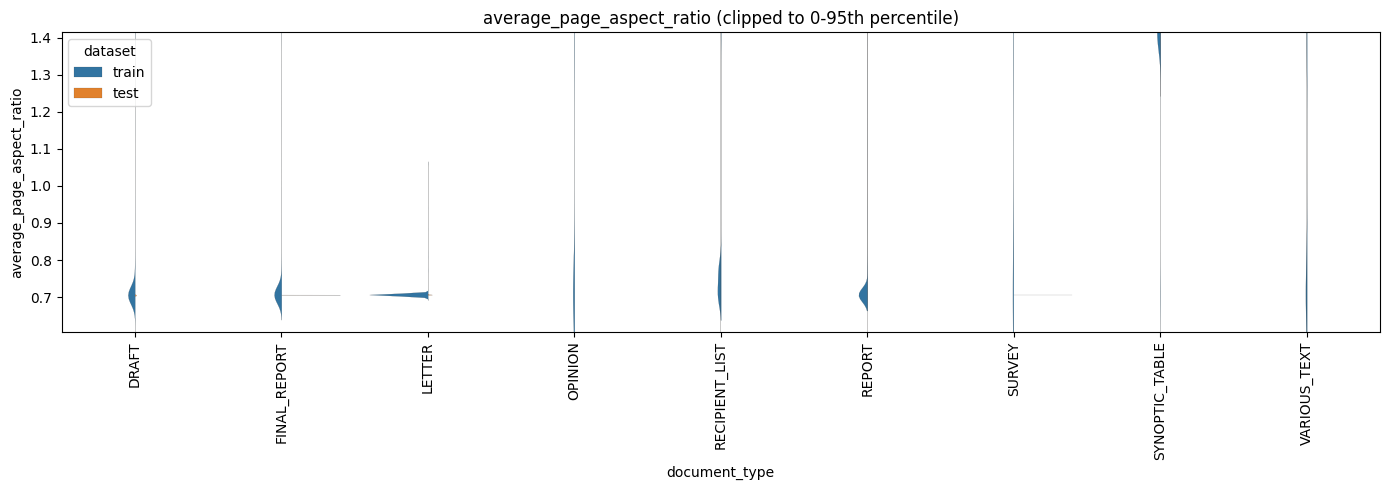

In [20]:
plot_feature_distribution_across_document_types(df_input, df_test_external, "count_pages", clip_y=(0, 90))
plot_feature_distribution_across_document_types(df_input, df_test_external, "average_page_aspect_ratio", clip_y=(0, 95))

In [21]:
pd.concat([df_input.assign(dataset="train"), df_test_external.assign(dataset="test")], axis=0).pivot_table(
    index="document_type",
    columns="dataset",
    values="count_pages",
    aggfunc=["mean", "std"],
    fill_value=0,
    observed=False,
)

mean                    std            
dataset              test       train       test       train
document_type                                               
DRAFT            9.307692   15.442079   7.238607   87.372185
FINAL_REPORT    53.750000   26.599415  64.912120   43.439166
LETTER           1.857143    2.168040   1.069045    1.425854
OPINION          0.000000  366.622593   0.000000  739.996939
RECIPIENT_LIST   4.000000    7.098474   3.207135    5.408546
REPORT          25.400000   24.746414  20.725416   30.775449
SURVEY           2.000000    3.911765   0.000000    5.333528
SYNOPTIC_TABLE   7.777778   10.997872   5.166667   13.965614
VARIOUS_TEXT     8.000000   16.193750  11.633286   27.146513

In [22]:
pd.concat([df_input.assign(dataset="train"), df_test_external.assign(dataset="test")], axis=0).pivot_table(
    index="document_type",
    columns="dataset",
    values="average_page_aspect_ratio",
    aggfunc=["mean", "std"],
    fill_value=0,
    observed=False,
)

mean                 std          
dataset             test     train      test     train
document_type                                         
DRAFT           0.705678  0.730675  0.000990  0.116140
FINAL_REPORT    0.706969  0.726509  0.000024  0.101385
LETTER          0.707235  0.707816  0.000479  0.014729
OPINION         0.000000  0.830498  0.000000  0.254391
RECIPIENT_LIST  0.972260  0.766632  0.366096  0.144461
REPORT          0.774360  0.724342  0.203589  0.085000
SURVEY          0.707098  0.909103  0.000000  0.319544
SYNOPTIC_TABLE  1.401125  1.370134  0.040129  0.165230
VARIOUS_TEXT    1.016457  0.911054  0.388462  0.316640

### Tables

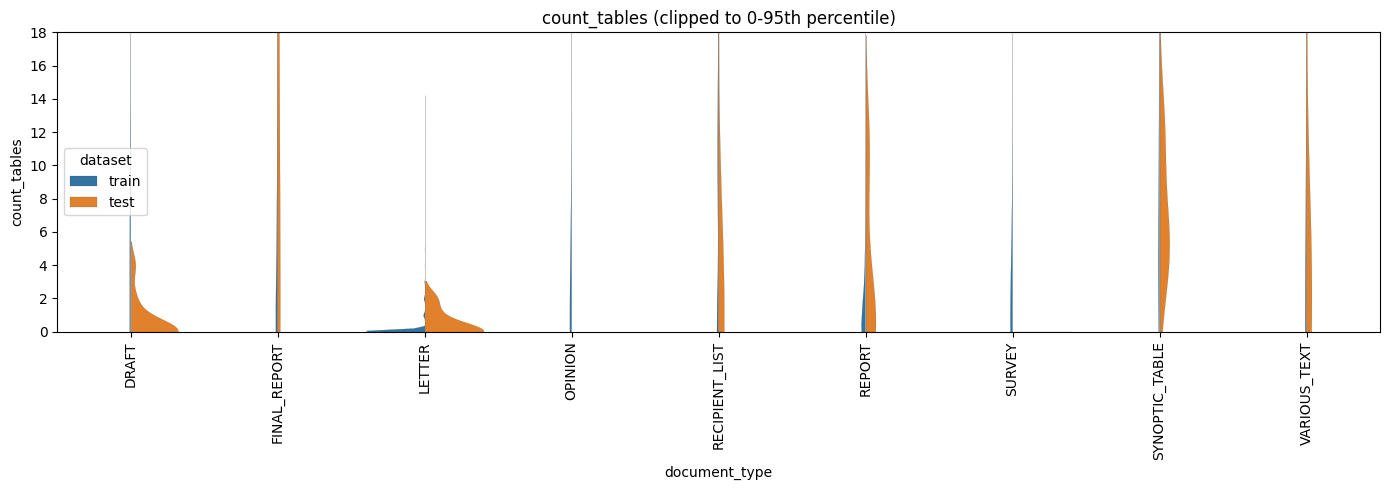

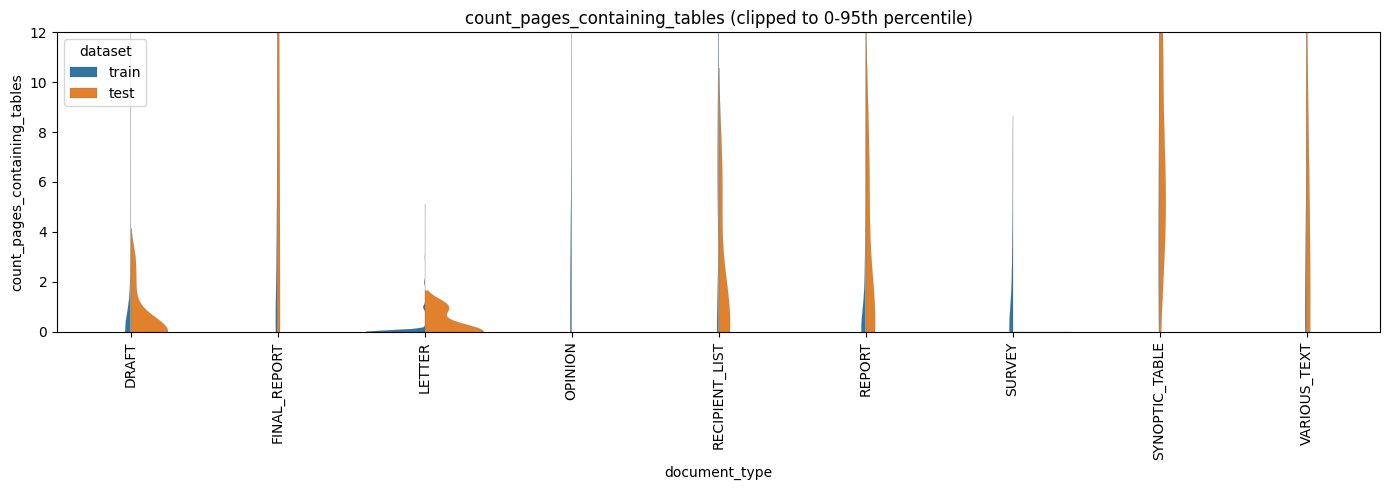

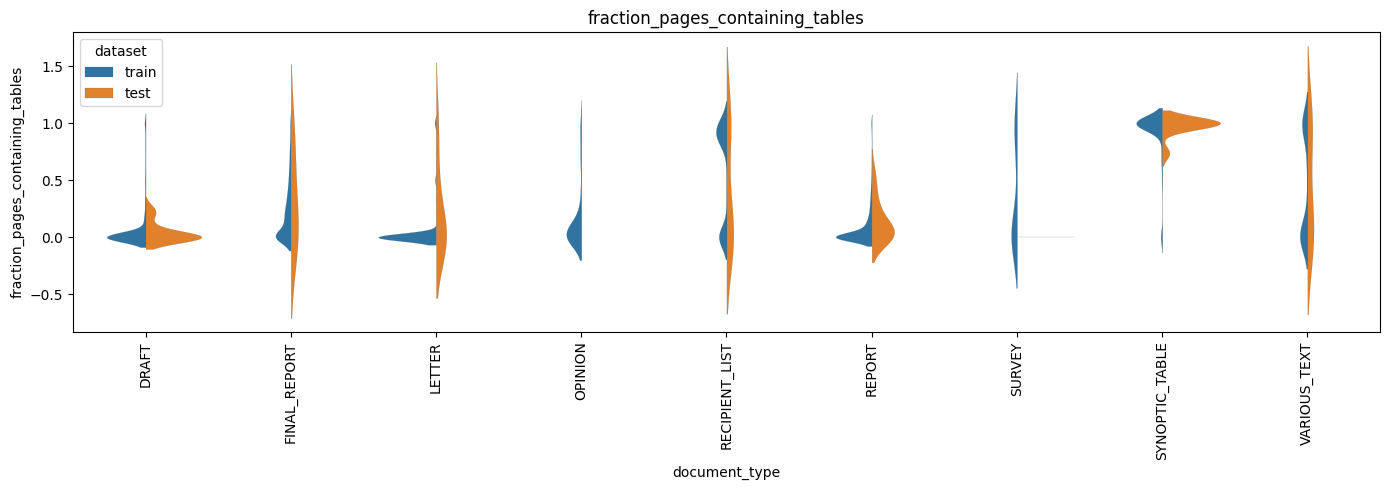

In [23]:
plot_feature_distribution_across_document_types(df_input, df_test_external, "count_tables", clip_y=(0, 95))
plot_feature_distribution_across_document_types(
    df_input, df_test_external, "count_pages_containing_tables", clip_y=(0, 95)
)
plot_feature_distribution_across_document_types(df_input, df_test_external, "fraction_pages_containing_tables")

### Images

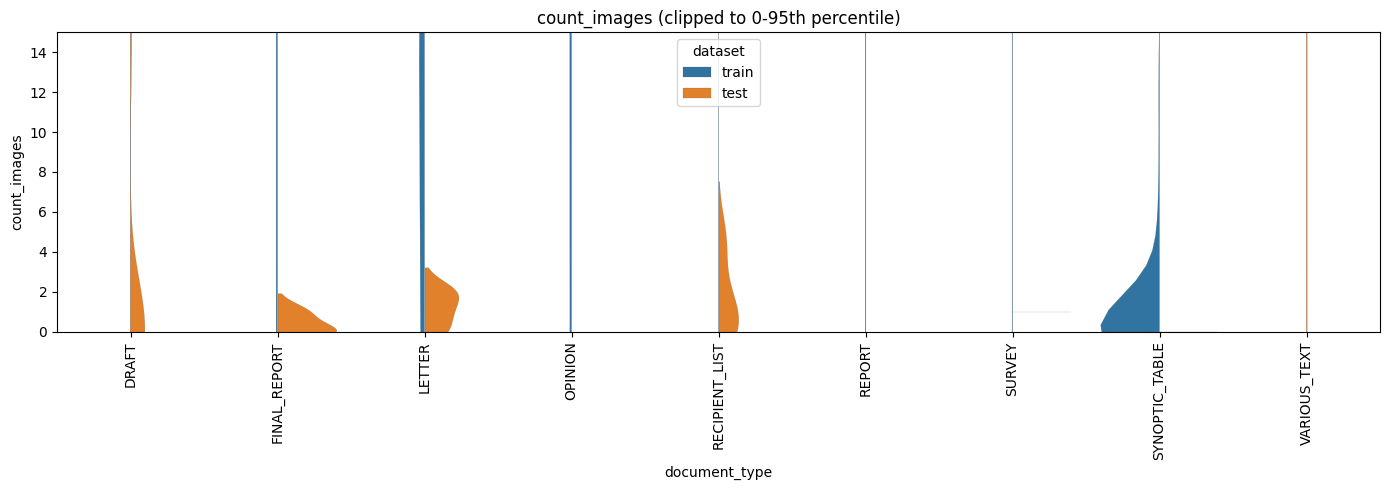

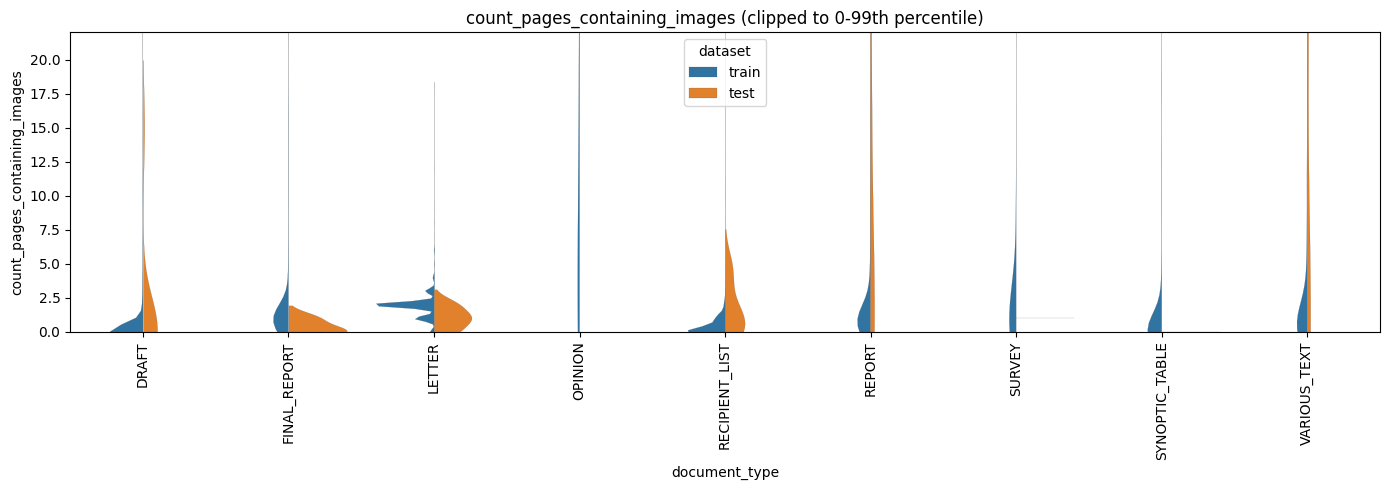

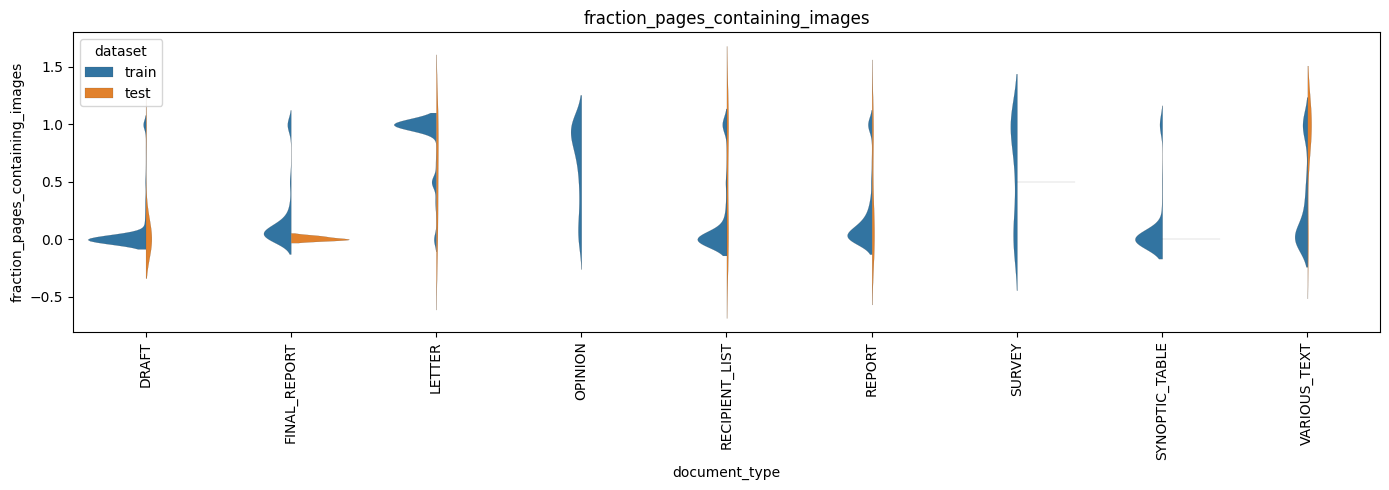

In [24]:
plot_feature_distribution_across_document_types(df_input, df_test_external, "count_images", clip_y=(0, 95))
plot_feature_distribution_across_document_types(
    df_input, df_test_external, "count_pages_containing_images", clip_y=(0, 99)
)
plot_feature_distribution_across_document_types(df_input, df_test_external, "fraction_pages_containing_images")

## Embeddings

In [25]:
EMBEDDINGS_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / EMBEDDINGS_FILE_NAME
data_access.ensure_dataframe_is_available(EMBEDDINGS_DATA_FILE)

df_embeddings = pd.read_parquet(EMBEDDINGS_DATA_FILE)
df_embeddings

,embedding
document_id,
1,"[0.01030252780765295, -0.014312159270048141, -..."
4,"[0.011395552195608616, 0.0014780974015593529, ..."
7,"[-0.005767590366303921, 0.002646328415721655, ..."
10,"[0.019797369837760925, -0.00907826703041792, -..."
13,"[-0.001758241094648838, 0.002000046195462346, ..."
...,...
54761,"[0.022786471992731094, 0.004644063767045736, -..."
54764,"[-0.0034232628531754017, -0.00898798368871212,..."
54765,"[0.004779078997671604, -0.008898445405066013, ..."


In [26]:
def add_embeddings(df: pd.DataFrame) -> pd.DataFrame:
    previous_shape = df.shape
    df = df.join(df_embeddings, on="document_id", how="inner")
    print(
        f"{previous_shape[0] - df.shape[0]} rows were lost due to missing embeddings. Remaining rows: {df.shape[0]}. "
        f"{df.shape[1] - previous_shape[1]} columns were added."
    )
    return df


df_input = add_embeddings(df_input)
df_test_external = add_embeddings(df_test_external)

9 rows were lost due to missing embeddings. Remaining rows: 13462. 1 columns were added.
0 rows were lost due to missing embeddings. Remaining rows: 64. 1 columns were added.


## Splits

### Set aside a test set

In [27]:
splitter = sklearn.model_selection.StratifiedShuffleSplit(
    n_splits=1,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

train_index, test_index = next(splitter.split(X=df_input, y=df_input["document_type"]))

In [28]:
df_input_train = df_input.iloc[train_index]
df_input_test = df_input.iloc[test_index]

print("Train:", df_input_train.shape)
print("Test:", df_input_test.shape)

Train: (12115, 36)
Test: (1347, 36)


In [29]:
mlflow.log_param("train_samples_count", len(df_input_train))
mlflow.log_param("test_samples_count", len(df_input_test))

1347

### Prepare a cross-validation splitter

In [30]:
cv_splitter = sklearn.model_selection.StratifiedKFold(
    n_splits=CV_FOLDS,
    shuffle=True,
    random_state=RANDOM_STATE,
)

# Classification

In [31]:
extra_feature_columns = [
    "contains_synopse_keyword",  # bool: whether the beginning of the document contains the word "synopse"
    "contains_salutation",  # bool: whether the beginning of the document contains a formal German letter greetings
    "contains_table_on_first_page",  # bool: whether the first page contains a table
    "count_pages",  # int: number of pages in the document
    "count_pages_containing_images",  # int: number of pages containing images (for documents <= 50 pages)
    "count_pages_containing_tables",  # int: number of pages containing tables (for documents <= 50 pages)
    "average_page_aspect_ratio",  # float: average aspect ratio of pages (width / height) (for documents <= 50 pages)
    # Removed: train/test distributions don't match well:
    #    "fraction_pages_containing_images",  # float: count_pages_containing_images / count_pages
    #    "fraction_pages_containing_tables",  # float: count_pages_containing_tables / count_pages
]
extra_categorical_feature_columns = [
    # "political_body",
    # "document_source",
]

mlflow.log_param("extra_feature_columns", sorted(extra_feature_columns))
mlflow.log_param("extra_categorical_feature_columns", sorted(extra_categorical_feature_columns))


def create_matrices(df: pd.DataFrame) -> tuple[np.ndarray, pd.Series]:
    embeddings = np.vstack(df["embedding"].tolist())
    x = np.hstack(
        (
            embeddings,
            df[extra_feature_columns].fillna(0),
            df[extra_categorical_feature_columns],
        )
    )
    y = df["document_type"]
    assert x.shape[0] == y.shape[0]
    return x, y


X_train, y_train = create_matrices(df_input_train)
X_test, y_test = create_matrices(df_input_test)
X_test_external, y_test_external = create_matrices(df_test_external)

print("train", X_train.shape)
print("test", X_test.shape)
print("test_external", X_test_external.shape)

train (12115, 3079)
test (1347, 3079)
test_external (64, 3079)


In [32]:
embedding_dimension = df_embeddings["embedding"].iloc[0].shape[0]

i_embeddings = 0
i_extra_features = i_embeddings + embedding_dimension
i_categorical_features = i_extra_features + len(extra_feature_columns)
assert i_categorical_features + len(extra_categorical_feature_columns) == X_train.shape[1]


def create_classifier() -> Pipeline:
    pca_step = None  # If this is set in the pipeline below, we'll log the number of components to MLflow.
    pipeline = make_pipeline(
        ColumnTransformer(
            [
                (
                    "embeddings",
                    make_pipeline(
                        StandardScaler(),
                        pca_step := PCA(n_components=20, random_state=RANDOM_STATE),
                    ),
                    slice(i_embeddings, i_extra_features),
                ),
                (
                    "extra_features",
                    make_pipeline(
                        StandardScaler(),
                    ),
                    slice(i_extra_features, i_categorical_features),
                ),
                # (
                #     "categorical_features",
                #     make_pipeline(
                #         OneHotEncoder(
                #             sparse_output=False,
                #             categories=[
                #                 # list(schemata.CANTON_CODES | {schemata.FEDERAL_CODE}),
                #                 # ["fedlex", "openparldata"],
                #             ],
                #         ),
                #         StandardScaler(),
                #     ),
                #     slice(i_categorical_features, None),
                # ),
            ]
        ),
        LogisticRegression(max_iter=2000),
        # GradientBoostingClassifier(random_state=RANDOM_STATE),
    )
    if pca_step is not None:
        mlflow.log_param("pca_n_components", pca_step.get_params()["n_components"])
    return pipeline


classifier = create_classifier()
classifier

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('embeddings',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=20,
                                                                       random_state=2718))]),
                                                  slice(0, 3072, None)),
                                                 ('extra_features',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  slice(3072, 3079, None))])),
                ('logisticregression', LogisticRegression(max_iter=2000))])

In [33]:
def explained_variance_scorer(pipeline: Pipeline, X: Any, y: Any = None) -> np.float64:
    try:
        pca = pipeline.named_steps["pca"]
    except KeyError:
        try:
            pca = pipeline.named_steps["columntransformer"].named_transformers_["embeddings"].named_steps["pca"]
        except (KeyError, AttributeError):
            return np.nan
    explained_variance = np.sum(pca.explained_variance_ratio_)
    return explained_variance


scoring = {
    "precision": "precision_weighted",
    "recall": "recall_weighted",
    "f1": "f1_weighted",
    "pca_explained_variance": explained_variance_scorer,
    "accuracy": "accuracy",
    "top_k_accuracy": "top_k_accuracy",
    # "top_k_accuracy": sklearn.metrics.make_scorer(sklearn.metrics.top_k_accuracy_score, k=3),
}

scores_docs = sklearn.model_selection.cross_validate(
    classifier,
    X=X_train,
    y=y_train,
    cv=cv_splitter,
    scoring=scoring,
)
scores_docs

{'fit_time': array([13.73837733,  8.04620624,  8.22805405,  7.46579194,  9.63438392]),
 'score_time': array([0.46976995, 0.48934698, 0.66948605, 0.33960605, 0.36294913]),
 'test_precision': array([0.92439808, 0.91824671, 0.92446577, 0.91342002, 0.91761142]),
 'test_recall': array([0.92901362, 0.92529922, 0.92860091, 0.91704499, 0.92199752]),
 'test_f1': array([0.92571262, 0.92030954, 0.92533164, 0.91453524, 0.91915493]),
 'test_pca_explained_variance': array([0.41718727, 0.41648643, 0.41653753, 0.41670393, 0.41701545]),
 'test_accuracy': array([0.92901362, 0.92529922, 0.92860091, 0.91704499, 0.92199752]),
 'test_top_k_accuracy': array([0.96945935, 0.96822121, 0.96698308, 0.96120512, 0.96822121])}

## Evaluation of the cross-validation

In [34]:
utils.log_metrics(
    **{k.replace("test_", "cv_"): np.round(np.mean(v), 4) for k, v in scores_docs.items() if k.startswith("test_")}
)

{'cv_accuracy': 0.9244,
 'cv_f1': 0.921,
 'cv_pca_explained_variance': 0.4168,
 'cv_precision': 0.9196,
 'cv_recall': 0.9244,
 'cv_top_k_accuracy': 0.9668}


### Use subsets of the training set to re-train and evaluate. This gives us a single model to run reports on. 

In [35]:
cv_test_splitter = sklearn.model_selection.StratifiedShuffleSplit(
    n_splits=1,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

cv_train_index, cv_test_index = next(cv_test_splitter.split(X=X_train, y=y_train))

X_cv_train = X_train[cv_train_index]
y_cv_train = y_train.iloc[cv_train_index]
X_cv_test = X_train[cv_test_index]
y_cv_test = y_train.iloc[cv_test_index]

In [36]:
classifier.fit(X_cv_train, y_cv_train)
cv_test_predictions = classifier.predict(X_cv_test)

2025/05/02 17:05:12 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/05/02 17:05:26 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


                precision    recall  f1-score   support

         DRAFT       0.91      0.92      0.92       249
  FINAL_REPORT       0.94      0.96      0.95       154
        LETTER       0.99      1.00      1.00       273
       OPINION       0.90      0.90      0.90        70
RECIPIENT_LIST       0.99      1.00      1.00       183
        REPORT       0.86      0.92      0.89       195
        SURVEY       0.00      0.00      0.00         3
SYNOPTIC_TABLE       0.85      0.79      0.81        42
  VARIOUS_TEXT       0.46      0.26      0.33        43

      accuracy                           0.92      1212
     macro avg       0.77      0.75      0.76      1212
  weighted avg       0.92      0.92      0.92      1212



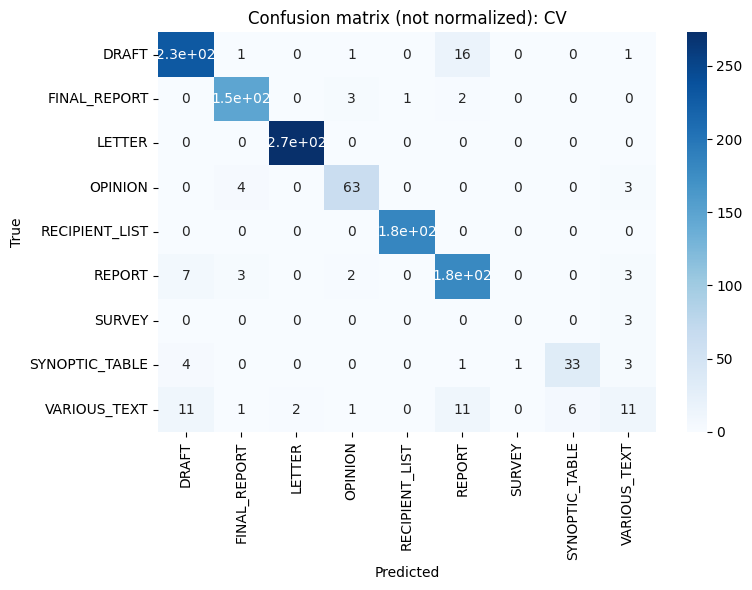

In [37]:
report = sklearn.metrics.classification_report(y_cv_test, cv_test_predictions, zero_division=np.nan)
mlflow.log_text(report, "cv_classification_report.txt")
print(report)
cm = plotting.plot_confusion_matrix_heatmap(y_cv_test, cv_test_predictions, title="CV")
mlflow.log_figure(cm, "cv_confusion_matrix.png")
display(cm)

### Feature importance

In [38]:
# explainer = shap.Explainer(classifier)  # .named_steps["logisticregression"])
# shap_values = explainer(X_cv_test)

# # visualize the first prediction's explanation
# shap.plots.waterfall(shap_values[0])


# def get_shap_values_for_complex_pipeline(pipeline, X_test):
#     # Extract preprocessing steps
#     column_transformer = pipeline.named_steps["columntransformer"]
#     classifier = pipeline.named_steps["logisticregression"]

#     # Transform a small batch of data for initialization
#     background_indices = np.random.choice(X_test.shape[0], 100, replace=False)
#     background_data = column_transformer.transform(X_test[background_indices])

#     # Create explainer with both model and background data
#     explainer = shap.KernelExplainer(classifier.predict, background_data)

#     # Transform the full test data
#     transformed_data = column_transformer.transform(X_test)

#     # Get SHAP values
#     shap_values = explainer.shap_values(transformed_data)

#     return shap_values


# Usage
# shap_values = get_shap_values_for_complex_pipeline(classifier, X_cv_test)
# shap_values


In [39]:
# importances = pd.Series(
#     classifier.named_steps["gradientboostingclassifier"].feature_importances_,
#     index=[f"embedding_{i:02d}" for i in range(20)] + extra_feature_columns,
# )
# importances.sort_values(ascending=False)

***

## Evaluation on the test set (USE SPARINGLY)

2025/05/02 17:05:34 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/05/02 17:05:50 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


                precision    recall  f1-score   support

         DRAFT       0.88      0.93      0.91       277
  FINAL_REPORT       0.92      0.97      0.95       171
        LETTER       0.99      1.00      1.00       303
       OPINION       0.96      0.94      0.95        78
RECIPIENT_LIST       1.00      0.99      0.99       203
        REPORT       0.89      0.91      0.90       216
        SURVEY       1.00      0.50      0.67         4
SYNOPTIC_TABLE       0.86      0.94      0.90        47
  VARIOUS_TEXT       0.61      0.29      0.39        48

      accuracy                           0.93      1347
     macro avg       0.90      0.83      0.85      1347
  weighted avg       0.93      0.93      0.93      1347



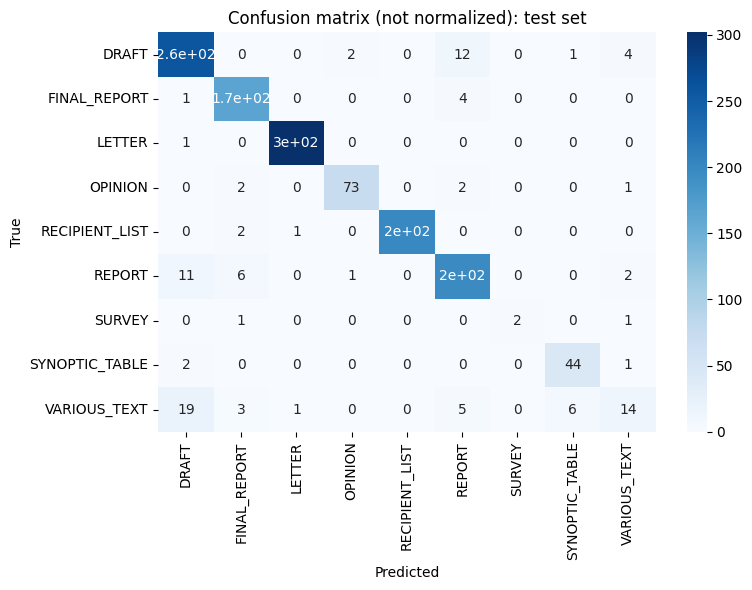

{'test_accuracy': 0.9317,
 'test_f1': 0.9267,
 'test_precision': 0.9268,
 'test_recall': 0.9317,
 'test_top_k_accuracy': 0.977}


In [40]:
if USE_TEST_SET:
    # Training & OOS predictions
    classifier_test = create_classifier()
    classifier_test.fit(X_train, y_train)
    test_ground_truth_docs = y_test
    test_predictions_docs = classifier_test.predict(X_test)

    # Classification report
    report = sklearn.metrics.classification_report(
        test_ground_truth_docs,
        test_predictions_docs,
        zero_division=np.nan,
    )
    mlflow.log_text(report, "test_classification_report.txt")
    print(report)

    # Confusion matrix
    cm = plotting.plot_confusion_matrix_heatmap(test_ground_truth_docs, test_predictions_docs, title="test set")
    mlflow.log_figure(cm, "test_confusion_matrix.png")
    display(cm)

    # Metrics
    p_r_f1 = sklearn.metrics.precision_recall_fscore_support(
        test_ground_truth_docs,
        test_predictions_docs,
        average="weighted",
        zero_division=np.nan,
    )
    utils.log_metrics(
        test_precision=p_r_f1[0],
        test_recall=p_r_f1[1],
        test_f1=p_r_f1[2],
        test_accuracy=sklearn.metrics.accuracy_score(test_ground_truth_docs, test_predictions_docs),
        test_top_k_accuracy=sklearn.metrics.top_k_accuracy_score(
            test_ground_truth_docs, classifier_test.predict_proba(X_test)
        ),
    )

***

# Rule-based & ML model evaluation

## Test both the rule-based model and the sklearn model on the external test set

Use both models to generate predictions:

In [41]:
# We must erase the true labels first because the rule-based model doesn't overwrite existing labels.
_df = df_test_external.copy()
_df.loc[:, "document_type"] = None
df_test_external["prediction_rule"] = data_loading.merge_classes(document_title_rule_model.predict(_df), MERGE_CLASSES)

In [42]:
classifier_external_test = create_classifier()
# classifier_external_test.fit(np.vstack((X_train, X_test)), pd.concat([y_train, y_test], ignore_index=True))
classifier_external_test.fit(X_train, y_train)

df_test_external["prediction_ml"] = classifier_external_test.predict(X_test_external)
df_test_external["prediction_ml_proba"] = classifier_external_test.predict_proba(X_test_external).tolist()

2025/05/02 17:05:59 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/05/02 17:06:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


### Display all samples

In [43]:
df_test_external[
    [
        "document_id",
        "political_body",
        "consultation_url",
        "document_source_url",
        "document_title",
        "document_type",
        "prediction_rule",
        "prediction_ml",
    ]
].style.format(
    {
        "consultation_url": lambda x: f'<a href="{x}">vnl</a>',
        "document_source_url": lambda x: f'<a href="{x}">doc</a>',
    }
).set_table_styles([{"selector": "th,td", "props": [("text-align", "left")]}])

,document_id,political_body,consultation_url,document_source_url,document_title,document_type,prediction_rule,prediction_ml
38660,38684,ag,vnl,doc,"Information (PDF, 8 Seiten, 450 KB)",REPORT,VARIOUS_TEXT,VARIOUS_TEXT
38664,38688,ag,vnl,doc,"Schreiben der Vorsteherin (PDF, 2 Seiten, 32 KB)",LETTER,LETTER,LETTER
38830,38854,ag,vnl,doc,"Adressatenliste (PDF, 5 Seiten, 26 KB)",RECIPIENT_LIST,RECIPIENT_LIST,RECIPIENT_LIST
39074,39098,ag,vnl,doc,"Beilage 3 zum Anhörungsbericht (Synopse GGV) (PDF, 2 Seiten, 81 KB)",SYNOPTIC_TABLE,SYNOPTIC_TABLE,SYNOPTIC_TABLE
39624,39760,ai,vnl,doc,Erläuternder Bericht zum Entwurf für ein Gesetz über die Nutzung des Untergrundes (GNU),REPORT,REPORT,REPORT
39706,39842,ai,vnl,doc,Entwurf Landsgemeindebeschluss über die Revision der Gerichtsorganisationsbestimmungen,DRAFT,DRAFT,DRAFT
39752,39888,ar,vnl,doc,Synopse,SYNOPTIC_TABLE,SYNOPTIC_TABLE,SYNOPTIC_TABLE
39761,39897,ar,vnl,doc,Liste der Vernehmlassungsadressaten,RECIPIENT_LIST,RECIPIENT_LIST,RECIPIENT_LIST
39769,39905,ar,vnl,doc,Erläuternder Bericht,REPORT,REPORT,REPORT
39912,40053,ar,vnl,doc,erläuternder Bericht,REPORT,REPORT,REPORT


In [44]:
# df_test_external.loc[df_test_external["document_id"] == 47461, "document_content_plain"].values[0]

In [45]:
df_test_external["document_type"].value_counts(dropna=False)

document_type
REPORT            15
DRAFT             13
SYNOPTIC_TABLE     9
RECIPIENT_LIST     8
VARIOUS_TEXT       7
LETTER             7
FINAL_REPORT       4
SURVEY             1
OPINION            0
DECISION           0
RESPONSE_FORM      0
LINK               0
PRESS_RELEASE      0
Name: count, dtype: int64

### ML model vs. ground truth

In [46]:
external_test_precision, external_test_recall, external_test_f1, _ = sklearn.metrics.precision_recall_fscore_support(
    df_test_external["document_type"],
    df_test_external["prediction_ml"],
    average="weighted",
    zero_division=np.nan,
)
utils.log_metrics(
    external_test_accuracy=sklearn.metrics.accuracy_score(
        df_test_external["document_type"], df_test_external["prediction_ml"]
    ),
    external_test_top_k_accuracy=sklearn.metrics.top_k_accuracy_score(
        df_test_external["document_type"],
        np.array(df_test_external["prediction_ml_proba"].tolist()),
        labels=sklearn.utils.multiclass.unique_labels(
            df_input_train["document_type"], df_test_external["document_type"]
        ),
    ),
    external_test_precision=external_test_precision,
    external_test_recall=external_test_recall,
    external_test_f1=external_test_f1,
)

{'external_test_accuracy': 0.8438,
 'external_test_f1': 0.8439,
 'external_test_precision': 0.8601,
 'external_test_recall': 0.8438,
 'external_test_top_k_accuracy': 0.9219}


                precision    recall  f1-score   support

         DRAFT       0.85      0.85      0.85        13
  FINAL_REPORT       1.00      0.75      0.86         4
        LETTER       1.00      1.00      1.00         7
       OPINION       0.00       nan      0.00         0
RECIPIENT_LIST       0.88      0.88      0.88         8
        REPORT       0.81      0.87      0.84        15
        SURVEY        nan      0.00      0.00         1
SYNOPTIC_TABLE       1.00      1.00      1.00         9
  VARIOUS_TEXT       0.57      0.57      0.57         7

      accuracy                           0.84        64
     macro avg       0.76      0.74      0.67        64
  weighted avg       0.86      0.84      0.84        64



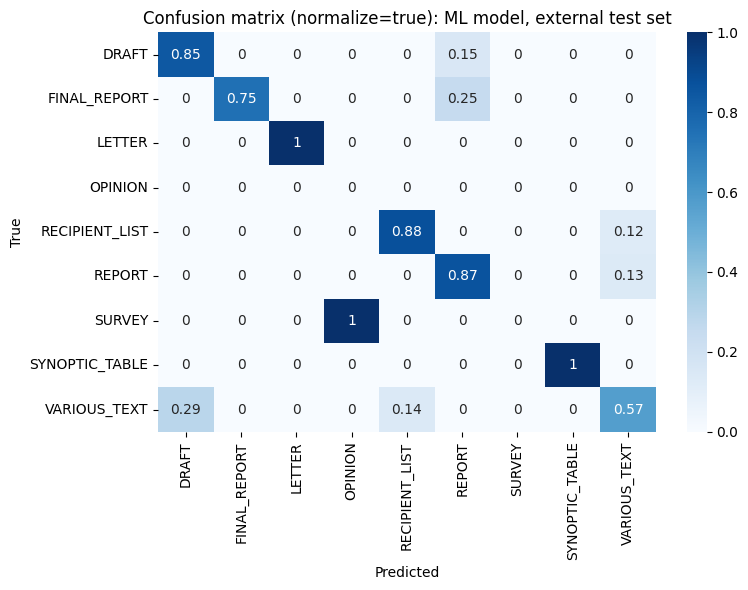

In [47]:
report = sklearn.metrics.classification_report(
    df_test_external["document_type"],
    df_test_external["prediction_ml"],
    zero_division=np.nan,
)
mlflow.log_text(report, "external_test_classification_report.txt")
print(report)

cm = plotting.plot_confusion_matrix_heatmap(
    df_test_external["document_type"],
    df_test_external["prediction_ml"],
    title="ML model, external test set",
    normalize="true",
)
mlflow.log_figure(cm, "external_test_confusion_matrix.png")
display(cm)

### Rule-based model vs. ground truth

                precision    recall  f1-score   support

         DRAFT       0.83      0.71      0.77         7
  FINAL_REPORT       1.00      0.67      0.80         3
        LETTER       1.00      1.00      1.00         6
RECIPIENT_LIST       1.00      0.86      0.92         7
        REPORT       0.90      0.90      0.90        10
        SURVEY       1.00      1.00      1.00         1
SYNOPTIC_TABLE       1.00      0.88      0.93         8
  VARIOUS_TEXT       0.43      1.00      0.60         3

      accuracy                           0.87        45
     macro avg       0.90      0.88      0.87        45
  weighted avg       0.91      0.87      0.88        45



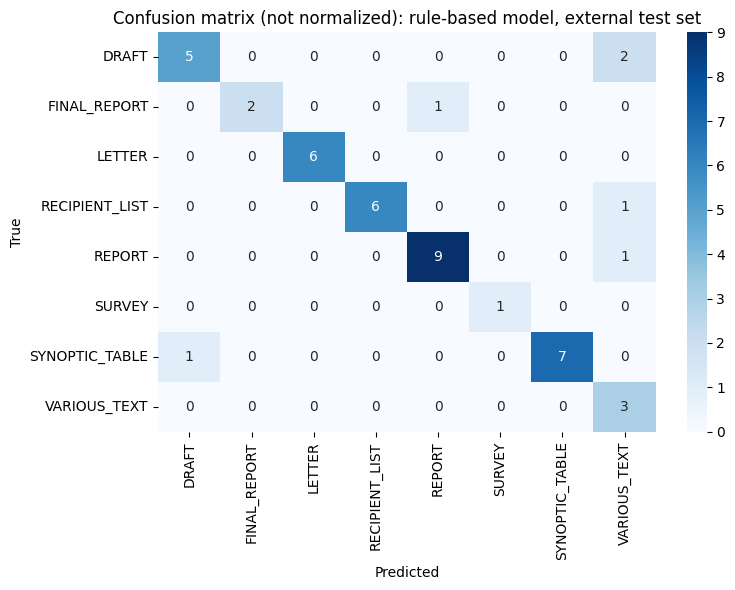

In [48]:
_df = df_test_external[df_test_external["prediction_rule"].notna()]
print(sklearn.metrics.classification_report(_df["document_type"], _df["prediction_rule"], zero_division=np.nan))
plotting.plot_confusion_matrix_heatmap(
    _df["document_type"],
    _df["prediction_rule"],
    title="rule-based model, external test set",
    # normalize="true",
)

***

# End MLflow run

In [49]:
mlflow.end_run()

🏃 View run trusting-doe-299 at: https://mlflow.ml1.demokratis.ch/#/experiments/2/runs/b3322f56ee8e4a24bf4b398d8fa7ee85
🧪 View experiment at: https://mlflow.ml1.demokratis.ch/#/experiments/2
